# PART III
## Kernel perceptron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from helpers import *

np.random.seed(1234)  # give a fixed seed for reproducability
from sklearn.model_selection import train_test_split

In [2]:
#loading data
zipcombo = np.loadtxt('zipcombo.dat')
zipcombo_qater = zipcombo[:len(zipcombo)//1]
training_data = np.loadtxt('dtrain123.dat')
test_data = np.loadtxt('dtest123.dat')

#some training data is continuous, need to make sure everything is either -1 or 1

(257,)


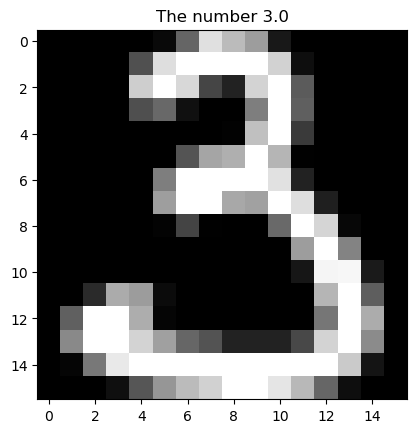

In [3]:
#plot first char
def plot_char(char):
    data = char[1:].reshape(16, 16)
    plt.imshow(data, cmap='gray')
    plt.title(f"The number {char[0]}")
    plt.show()
print(training_data[0].shape)
    
plot_char(training_data[0])

In [4]:
##helper functions(can be extracted into a separate class later)

#polynomial kernel

def polynomial_kernel(p, q, d):
    return (1 + (p@q.T)) ** d

def polynomial_kernel_3D(p, q, d):
    #returns a 3D array of the polynomial kernel of the data, last dimension is the degree
    kernels = np.empty((len(d), len(q), len(p)))
    for i, degree in enumerate(d):
        kernels[i, :, :] = (1 + np.dot(p, q.T)) ** degree

    return kernels

#Gaussian kernel
def gaussian_kernel(p, q, sigma):
    #from previous coursework: exp(-||p-q||^2 / 2*sigma^2)
    return np.exp(-np.linalg.norm(p - q) ** 2 / (2 * sigma ** 2))

#convering the data to -1 and 1
def mysign(data):
    return np.where(data <= 0.0, -1.0, 1.0)

#splitting data and labels
def split_into_data_and_labels(data):
    y = data[:,0].astype(int)
    #convert to -1 and 1 here instead of in the loop
    x = data[:, 1:]
    return x, y

In [5]:
def train_kernel_perceptron_online(X, y, K, n_classes, return_training_error=True):
    NB_EPOCHS_MAX = 30
    num_samples = X.shape[0]
    alpha = np.zeros((n_classes, num_samples))
    total_mistakes = 0
    prev_error = float('inf') 
    epoches = 0
    for epoch in range(NB_EPOCHS_MAX):
        for i in range(num_samples):
            scores = np.zeros(n_classes)
            
            scores = K[i]@alpha.T
            predicted_class = np.argmax(scores)
            true_class = y[i]

            if predicted_class != true_class:
                alpha[true_class, i] += 1
                alpha[predicted_class, i] -=1
                total_mistakes += 1  # Increment the total number of mistakes
                
        epoches+=1
                    
        print(f"Epoches {epoches}, number of sumples {num_samples}, total mistakes {total_mistakes}")
        
        train_error = total_mistakes / (epoches * num_samples)  # Calculate the training error
        
        # convergence
        if (prev_error - train_error) < 1e-2:
            break
        prev_error = train_error
    if(return_training_error):
        return alpha, train_error
    
    return alpha

In [6]:
def predict_kernel_perceptron(y, alpha, K, return_labels=False):
    # Calculate the scores for all test samples and classes at once
    scores = np.dot(alpha, K.T)

    # Predict the class with the highest score for each test sample
    y_pred = np.argmax(scores, axis=0)

    test_error = np.mean(y != y_pred)
    if(return_labels):
        return test_error, y_pred
    return test_error

## Q1

In [7]:
N_RUNS = 20
d_range = np.arange(1, 8, dtype=int)  # k = 1...7
#substitute for the real data with 10
x_data, y_labels = split_into_data_and_labels(zipcombo_qater)
#can be extraced from data
n_classes = len(np.unique(y_labels))

def run_experiment(x_data, y_labels, N_RUNS, d, n_classes):
    train_errors = np.zeros((N_RUNS, len(d_range)))
    train_errors2 = np.zeros((N_RUNS, len(d_range)))
    test_errors = np.zeros((N_RUNS, len(d_range)))

    for i_run in range(N_RUNS):
        X_train, X_test, y_train, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        n_training_samples = X_train.shape[0]

        for j_ind, j in enumerate(d_range):
            K_train = polynomial_kernel(X_train, X_train, j)
            
            alpha, train_errors[i_run, j_ind] = train_kernel_perceptron_online(X_train, y_train, K_train, n_classes)
            train_errors2[i_run, j_ind] = predict_kernel_perceptron(y_train, alpha, K_train)

            print(f"Run {i_run}, degree {j}, train error {train_errors[i_run, j_ind]}, number of samples {n_training_samples}")
            
            # calculating prediction of the test data
            K_test = polynomial_kernel(X_test, X_train, j)
            test_errors[i_run, j_ind] = predict_kernel_perceptron(y_test, alpha, K_test)
            print(f"Run {i_run}, degree {j}, test error {test_errors[i_run, j_ind]}, number of samples {len(X_test)}")

    mean_train_errors = np.mean(train_errors, axis=0)
    mean_test_errors = np.mean(test_errors, axis=0)
    mean_std_train_errors = np.std(train_errors, axis=0)
    mean_std_test_errors = np.std(test_errors, axis=0)
    
    return mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors

mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors = run_experiment(x_data, y_labels, N_RUNS, d_range, n_classes)

Epoches 1, number of sumples 7438, total mistakes 1113
Epoches 2, number of sumples 7438, total mistakes 1827
Epoches 3, number of sumples 7438, total mistakes 2449
Epoches 4, number of sumples 7438, total mistakes 3028
Run 0, degree 1, train error 0.10177467061037913, number of samples 7438
Run 0, degree 1, test error 0.0967741935483871, number of samples 1860
Epoches 1, number of sumples 7438, total mistakes 784
Epoches 2, number of sumples 7438, total mistakes 1111
Epoches 3, number of sumples 7438, total mistakes 1303
Epoches 4, number of sumples 7438, total mistakes 1452
Run 0, degree 2, train error 0.04880344178542619, number of samples 7438
Run 0, degree 2, test error 0.05698924731182796, number of samples 1860
Epoches 1, number of sumples 7438, total mistakes 678
Epoches 2, number of sumples 7438, total mistakes 881
Epoches 3, number of sumples 7438, total mistakes 997
Epoches 4, number of sumples 7438, total mistakes 1080
Run 0, degree 3, train error 0.036300080666845924, numb

In [8]:
# Create a summary table
columns = ['degree', 'mean training error', 'mean train std', 'mean test error', 'mean test std']

# Take an average over all the runs
kernel_perceptron = pd.concat((
    pd.DataFrame(mean_train_errors, columns=[columns[1]]),
    pd.DataFrame(mean_std_train_errors,columns=[columns[2]]),
    pd.DataFrame(mean_test_errors, columns=[columns[3]]),
    pd.DataFrame(mean_std_test_errors, columns=[columns[4]])), axis=1
)
kernel_perceptron.set_index('Polynomial degree ' + pd.Series(d_range).astype(str), inplace=True)
kernel_perceptron.index.name = 'degree'
kernel_perceptron = kernel_perceptron.style.format("{:.5f}")

kernel_perceptron


,mean training error,mean train std,mean test error,mean test std
degree,,,,
Polynomial degree 1,0.10560,0.00206,0.09530,0.01336
Polynomial degree 2,0.04673,0.00317,0.04562,0.00650
Polynomial degree 3,0.03602,0.00066,0.03941,0.00858
Polynomial degree 4,0.03053,0.00077,0.03398,0.00452
Polynomial degree 5,0.02784,0.00067,0.03156,0.00379
Polynomial degree 6,0.02648,0.00054,0.03309,0.00443
Polynomial degree 7,0.02585,0.00069,0.03417,0.00381


## Q2

In [9]:
N_FOLDS = 5
fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
test_errors = np.zeros(shape=(N_RUNS))
d_stars = []

for i_run in range(N_RUNS):
    # Use i_run as random state so each run is different but the test_train_split matches the runs
    X_train, X_test, Y_train, Y_test = train_test_split(
        x_data, y_labels, test_size= 0.2, random_state=i_run
    )

    folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)

    # Loop to pick the best d_star based on the lowest cross validation error
    for i_fold, fold in enumerate(folds_data):
        fold: FoldData
        for i_j, j in enumerate(d_range):
            K_train_fold = polynomial_kernel(fold.train_data, fold.train_data, j)
            K_test_fold = polynomial_kernel(fold.test_data, fold.train_data, j)
            alpha = train_kernel_perceptron_online(fold.train_data, fold.train_labels, K_train_fold, n_classes, return_training_error = False)

            fold_test_prediction_error[i_run, i_fold, i_j] = predict_kernel_perceptron(fold.test_labels, alpha, K_test_fold)

    # Pick the d star based on the lowest test error
    d_star, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=d_range)
    d_stars.append(d_star)

    # Create a new classifier based on d star and retrained on the whole training set
    K_train = polynomial_kernel(X_train, X_train, d=d_star)
    alpha_star = train_kernel_perceptron_online(X_train, Y_train, K_train, n_classes, return_training_error=False)

    # Get the error of the new training and testing over the whole dataset for this new predictor
    K_test = polynomial_kernel(X_test, X_train, d=d_star)
    test_errors[i_run] = predict_kernel_perceptron(Y_test, alpha_star, K_test)

Epoches 1, number of sumples 5951, total mistakes 961
Epoches 2, number of sumples 5951, total mistakes 1557
Epoches 3, number of sumples 5951, total mistakes 2066
Epoches 4, number of sumples 5951, total mistakes 2545
Epoches 1, number of sumples 5951, total mistakes 670
Epoches 2, number of sumples 5951, total mistakes 941
Epoches 3, number of sumples 5951, total mistakes 1100
Epoches 4, number of sumples 5951, total mistakes 1237
Epoches 1, number of sumples 5951, total mistakes 577
Epoches 2, number of sumples 5951, total mistakes 783
Epoches 3, number of sumples 5951, total mistakes 870
Epoches 4, number of sumples 5951, total mistakes 926
Epoches 1, number of sumples 5951, total mistakes 550
Epoches 2, number of sumples 5951, total mistakes 693
Epoches 3, number of sumples 5951, total mistakes 751
Epoches 4, number of sumples 5951, total mistakes 788
Epoches 1, number of sumples 5951, total mistakes 539
Epoches 2, number of sumples 5951, total mistakes 660
Epoches 3, number of su

In [10]:
d_stars
test_errors
print(d_stars)
print(test_errors)
mean_cross_validation_test_error = np.mean(test_errors, axis=0)
mean_cross_validation_test_error_std = np.std(test_errors, axis=0)
mean_cross_validation_d = np.mean(d_stars)
mean_cross_validation_s_std = np.std(d_stars)
print("Mean Test Error: ", mean_cross_validation_test_error, "±", mean_cross_validation_test_error_std)
print("Mean Best d: ", mean_cross_validation_d, "±", mean_cross_validation_s_std)

part_2_results = {
        "Mean Best d": mean_cross_validation_d,
        "Std Best d": mean_cross_validation_s_std,
        "Mean Test Error": mean_cross_validation_test_error,
        "Std Test Error": mean_cross_validation_test_error_std
    }

df_mean_error_rates = pd.DataFrame(mean_cross_validation_d, index=np.arange(10), columns=np.arange(10))
df_std_error_rates = pd.DataFrame(mean_cross_validation_s_std, index=np.arange(10), columns=np.arange(10))

df_restuls_2 = pd.DataFrame.from_dict(part_2_results, orient='index')
df_restuls_2.reset_index(inplace=True)
df_restuls_2

[5, 6, 4, 5, 6, 5, 6, 6, 6, 4, 7, 6, 7, 5, 5, 6, 5, 5, 5, 6]
[0.02795699 0.02634409 0.03494624 0.03387097 0.03387097 0.03817204
 0.03333333 0.03172043 0.02795699 0.03709677 0.03870968 0.02849462
 0.03548387 0.02849462 0.03010753 0.02795699 0.03924731 0.0327957
 0.03225806 0.0311828 ]
Mean Test Error:  0.032499999999999994 ± 0.003852536016850258
Mean Best d:  5.5 ± 0.806225774829855


,index,0
0,Mean Best d,5.500000
1,Std Best d,0.806226
2,Mean Test Error,0.032500
3,Std Test Error,0.003853


## Q3

In [11]:
def confusion_matrix(y_true, y_pred):
    classes = np.unique(y_true)
    matrix = np.zeros((len(classes), len(classes)))

    for true_class in classes:
        for pred_class in classes:
            if true_class != pred_class:  # Exclude diagonal elements
                matrix[true_class, pred_class] = np.sum((y_true == true_class) & (y_pred == pred_class)) / np.sum(y_true == true_class)

    return matrix

def calculate_std_dev(confusion_matrices):
    return np.std(confusion_matrices, axis=0)

In [12]:
fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
test_errors = np.zeros(shape=(N_RUNS))
test_errors = np.zeros(shape=(N_RUNS))
confusion_matrices = np.zeros(shape=(N_RUNS, n_classes, n_classes))


for i_run in range(N_RUNS):
    # Use i_run as random state so each run is different but the test_train_split matches the runs
    X_train, X_test, Y_train, Y_test = train_test_split(
        x_data, y_labels, test_size= 0.2, random_state=i_run
    )

    folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)

    # Loop to pick the best d_star based on the lowest cross validation error
    for i_fold, fold in enumerate(folds_data):
        fold: FoldData
        for i_j, j in enumerate(d_range):
            K_train_fold = polynomial_kernel(fold.train_data, fold.train_data, j)
            K_test_fold = polynomial_kernel(fold.test_data, fold.train_data, j)
            alpha = train_kernel_perceptron_online(fold.train_data, fold.train_labels, K_train_fold, n_classes, return_training_error = False)

            fold_test_prediction_error[i_run, i_fold, i_j] = predict_kernel_perceptron(fold.test_labels, alpha, K_test_fold)

    # Pick the d star based on the lowest test error
    d_star, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=d_range)

    # Create a new classifier based on d star and retrained on the whole training set
    K_train = polynomial_kernel(X_train, X_train, d=d_star)
    alpha_star = train_kernel_perceptron_online(X_train, Y_train, K_train, n_classes, return_training_error=False)

    # Get the error of the new training and testing over the whole dataset for this new predictor
    K_test = polynomial_kernel(X_test, X_train, d=d_star)
    test_errors[i_run], y_pred = predict_kernel_perceptron(Y_test, alpha_star, K_test, return_labels=True)
    confusion_matrices[i_run, :, :] = confusion_matrix(Y_test, y_pred)

Epoches 1, number of sumples 5951, total mistakes 961
Epoches 2, number of sumples 5951, total mistakes 1557
Epoches 3, number of sumples 5951, total mistakes 2066
Epoches 4, number of sumples 5951, total mistakes 2545
Epoches 1, number of sumples 5951, total mistakes 670
Epoches 2, number of sumples 5951, total mistakes 941
Epoches 3, number of sumples 5951, total mistakes 1100
Epoches 4, number of sumples 5951, total mistakes 1237
Epoches 1, number of sumples 5951, total mistakes 577
Epoches 2, number of sumples 5951, total mistakes 783
Epoches 3, number of sumples 5951, total mistakes 870
Epoches 4, number of sumples 5951, total mistakes 926
Epoches 1, number of sumples 5951, total mistakes 550
Epoches 2, number of sumples 5951, total mistakes 693
Epoches 3, number of sumples 5951, total mistakes 751
Epoches 4, number of sumples 5951, total mistakes 788
Epoches 1, number of sumples 5951, total mistakes 539
Epoches 2, number of sumples 5951, total mistakes 660
Epoches 3, number of su

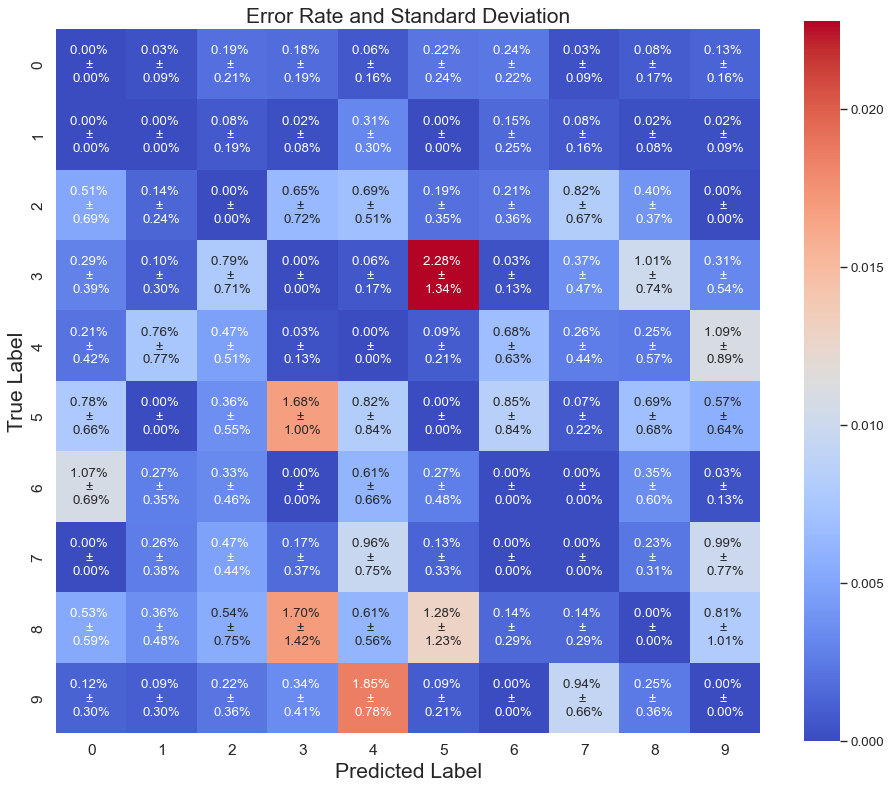

In [13]:
std_dev_matrix = calculate_std_dev(confusion_matrices)
mean_confusion_matrix = confusion_matrices.mean(axis=0)
combined_matrix = np.vectorize(lambda mean, std: f"{mean*100:.2f}% \n± \n{std*100:.2f}%")(mean_confusion_matrix, std_dev_matrix)

plt.figure(figsize=(12, 10), dpi=80)
sns.set(style="whitegrid", font_scale=1.1)
ax = sns.heatmap(mean_confusion_matrix, annot=combined_matrix, fmt="", cmap='coolwarm', cbar=True, square=True, annot_kws={"size": 12}, xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title("Confusion matrix")
plt.title("Error Rate and Standard Deviation", fontsize=19)
plt.xlabel('Predicted Label', fontsize=19)
plt.ylabel('True Label', fontsize=19)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

## Q4

In [14]:
N_RUNS = 20
fold_test_prediction_error = np.zeros(shape=(N_RUNS, N_FOLDS, len(d_range)))
test_errors = np.zeros(shape=(N_RUNS))
test_errors = np.zeros(shape=(N_RUNS))
misclassified_images = {}

for i_run in range(N_RUNS):
    # Use i_run as random state so each run is different but the test_train_split matches the runs
    X_train, X_test, Y_train, Y_test = train_test_split(
        x_data, y_labels, test_size= 0.2, random_state=i_run
    )

    folds_data: list[FoldData] = create_folds_data(X_train, Y_train, number_of_folds=N_FOLDS)

    # Loop to pick the best d_star based on the lowest cross validation error
    for i_fold, fold in enumerate(folds_data):
        fold: FoldData
        for i_j, j in enumerate(d_range):
            K_train_fold = polynomial_kernel(fold.train_data, fold.train_data, j)
            K_test_fold = polynomial_kernel(fold.test_data, fold.train_data, j)
            alpha = train_kernel_perceptron_online(fold.train_data, fold.train_labels, K_train_fold, n_classes, return_training_error = False)

            fold_test_prediction_error[i_run, i_fold, i_j] = predict_kernel_perceptron(fold.test_labels, alpha, K_test_fold)

    # Pick the d star based on the lowest test error
    d_star, _ = get_d_star_from_cross_validation_error(fold_test_prediction_error[i_run, :, :], ds=d_range)

    # Create a new classifier based on d star and retrained on the whole training set
    K_train = polynomial_kernel(X_train, X_train, d=d_star)
    alpha_star = train_kernel_perceptron_online(X_train, Y_train, K_train, n_classes, return_training_error=False)

    # Get the error of the new training and testing over the whole dataset for this new predictor
    K_test = polynomial_kernel(X_test, X_train, d=d_star)
    test_errors[i_run], y_pred = predict_kernel_perceptron(Y_test, alpha_star, K_test, return_labels=True)
    misclassified_indices = np.where(y_pred!=Y_test)[0]
    misclassified_images[i_run] = {}
    for index in misclassified_indices:
        true_label = Y_test[index]
        misclassified_images[i_run][true_label] = X_test[index]
    

Epoches 1, number of sumples 5951, total mistakes 961
Epoches 2, number of sumples 5951, total mistakes 1557
Epoches 3, number of sumples 5951, total mistakes 2066
Epoches 4, number of sumples 5951, total mistakes 2545
Epoches 1, number of sumples 5951, total mistakes 670
Epoches 2, number of sumples 5951, total mistakes 941
Epoches 3, number of sumples 5951, total mistakes 1100
Epoches 4, number of sumples 5951, total mistakes 1237
Epoches 1, number of sumples 5951, total mistakes 577
Epoches 2, number of sumples 5951, total mistakes 783
Epoches 3, number of sumples 5951, total mistakes 870
Epoches 4, number of sumples 5951, total mistakes 926
Epoches 1, number of sumples 5951, total mistakes 550
Epoches 2, number of sumples 5951, total mistakes 693
Epoches 3, number of sumples 5951, total mistakes 751
Epoches 4, number of sumples 5951, total mistakes 788
Epoches 1, number of sumples 5951, total mistakes 539
Epoches 2, number of sumples 5951, total mistakes 660
Epoches 3, number of su

{2: 20, 8: 20, 9: 20, 1: 14, 5: 20, 6: 20, 4: 20, 3: 20, 7: 20, 0: 19}
5


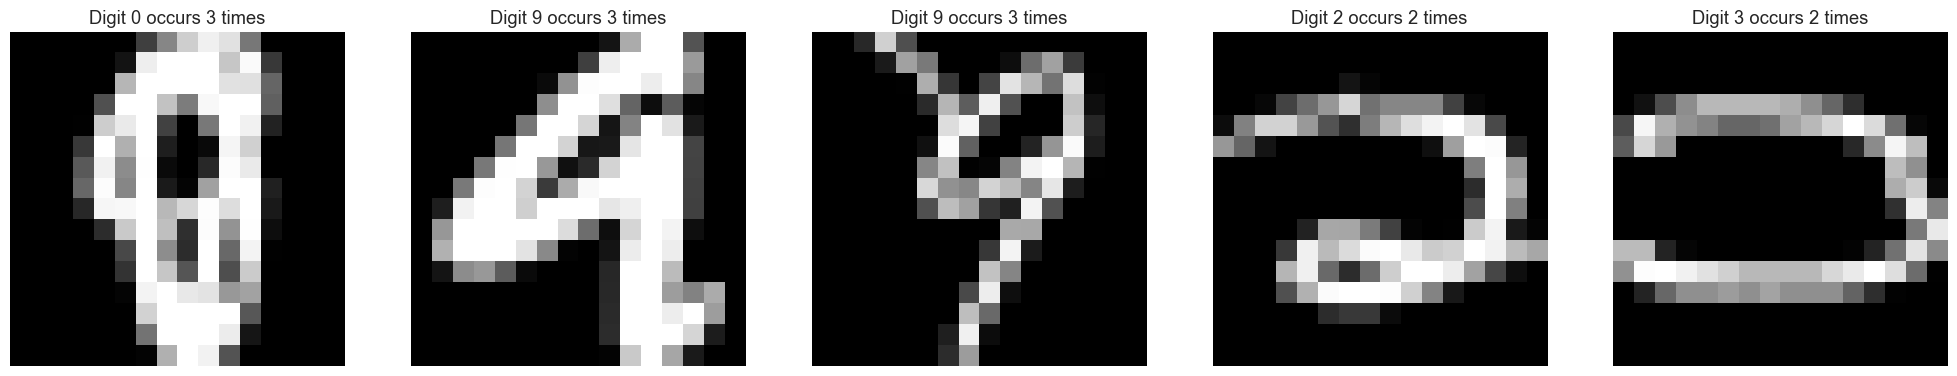

In [15]:
from collections import Counter
label_counts = {}
image_counts = Counter()
image_data = []


for i_run in misclassified_images:
    for label in misclassified_images[i_run]:
        if label not in label_counts:
            label_counts[label] = 0
        label_counts[label] +=1
        image = tuple(misclassified_images[i_run][label].flatten())
        if image not in image_counts:
            image_counts[image] = 1
            image_data.append({'image': image, 'count': image_counts[image], 'label': label})
        else:
            image_counts[image] += 1
            # Find the corresponding dictionary in image_data and update its count
            for image_dict in image_data:
                if image_dict['image'] == image:
                    image_dict['count'] = image_counts[image]
                    break
  
print(label_counts)

total_counts = {}

# Iterate over the images in image_data
for image_dict in image_data:
    image, count, label = image_dict['image'], image_dict['count'], image_dict['label']

    # If the image is already in total_counts, add the count to the existing count
    # Otherwise, set the count and label as the total count and label for this image
    if image in total_counts:
        total_counts[image]['count'] += count
    else:
        total_counts[image] = {'count': count, 'label': label}

# Convert total_counts back to a list of dictionaries
image_data = [{'image': image, 'count': data['count'], 'label': data['label']} for image, data in total_counts.items()]

#print image that is most misclassified
#most_common_images = image_data.image_counts.most_common(5)
image_data.sort(key=lambda x: x['count'], reverse=True)

# Get the 5 most common images
most_common_images = image_data[:5]
print(len(most_common_images))
# Create a figure with multiple subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))

# Display each of the 5 most common images in its own subplot
for ax, data in zip(axes, most_common_images):
    image, count, label = data['image'], data['count'], data['label']

    image = np.array(image).reshape(16, 16)
    # Display the image
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    # Display the count as the title of the subplot
    ax.set_title(f"Digit {label} occurs {count} times")

plt.show()




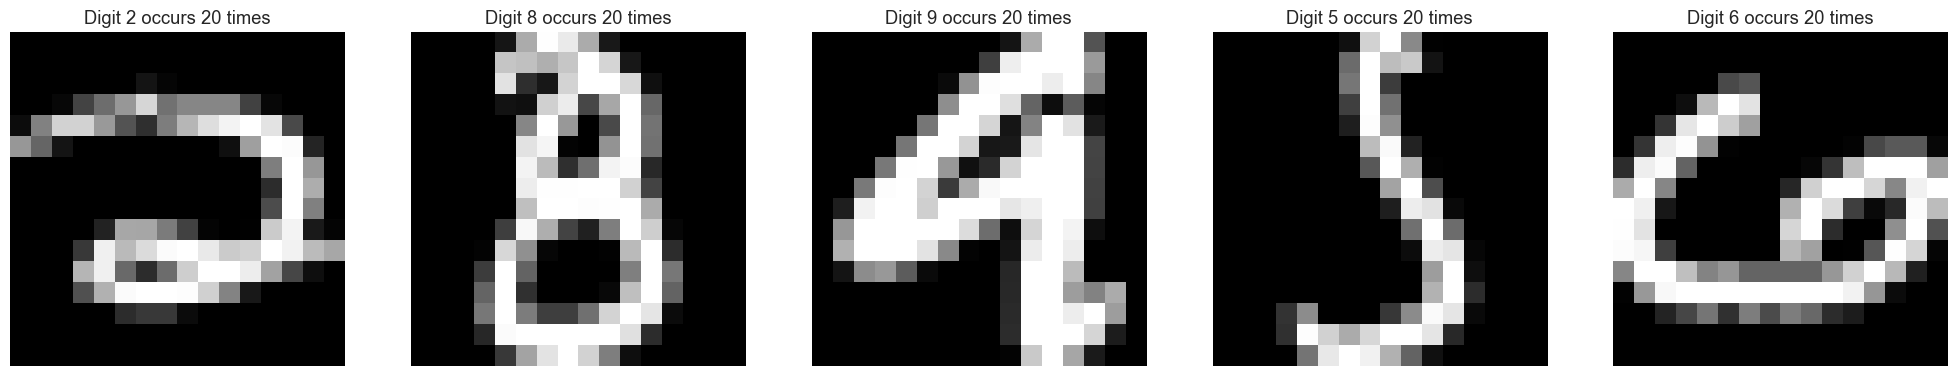

In [16]:
def get_first_image_by_label(label):
    for image_dict in image_data:
        if image_dict['label'] == label:
            return image_dict['image']

fig, axes = plt.subplots(1, 5, figsize=(25, 5))
most_common_labels = Counter(label_counts).most_common(5)

for ax, label_data in zip(axes, most_common_labels):
    label, count = label_data[0], label_data[1]
    image1 = np.array(get_first_image_by_label(label)).reshape(16, 16)
    ax.imshow(image1, cmap='gray')
    ax.axis('off')
    # Display the count as the title of the subplot
    ax.set_title(f"Digit {label} occurs {count} times")

plt.show()

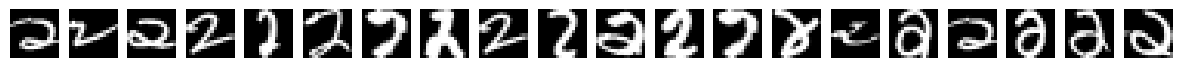

In [17]:
most_misclassified_label = max(label_counts, key=label_counts.get)
label_counter = Counter(label_counts)
most_common_labels = label_counter.most_common(5)
most_misclassified_images = []
for i_run in misclassified_images:
    if most_misclassified_label in misclassified_images[i_run]:
        most_misclassified_images.append(misclassified_images[i_run][most_misclassified_label])

fig, axes = plt.subplots(1, len(most_misclassified_images), figsize=(15, 5))

for ax, image in zip(axes, most_misclassified_images):
    
    data = image.reshape(16, 16)
    ax.imshow(data, cmap='gray')
    ax.axis('off')

plt.show()

## Q5

In [18]:
N_RUNS = 20
d_range = np.arange(1, 8, dtype=int)  # k = 1...7
#substitute for the real data with 10
x_data, y_labels = split_into_data_and_labels(zipcombo_qater)
#can be extraced from data
n_classes = len(np.unique(y_labels))

def run_experiment(x_data, y_labels, N_RUNS, d, n_classes):
    train_errors = np.zeros((N_RUNS, len(d_range)))
    train_errors2 = np.zeros((N_RUNS, len(d_range)))
    test_errors = np.zeros((N_RUNS, len(d_range)))

    for i_run in range(N_RUNS):
        X_train, X_test, y_train, y_test = train_test_split(
            x_data, y_labels, test_size=0.2, random_state=i_run
        )
        n_training_samples = X_train.shape[0]

        for j_ind, j in enumerate(d_range):
            K_train = polynomial_kernel(X_train, X_train, j)
            
            alpha, train_errors[i_run, j_ind] = train_kernel_perceptron_online(X_train, y_train, K_train, n_classes)
            train_errors2[i_run, j_ind] = predict_kernel_perceptron(y_train, alpha, K_train)

            print(f"Run {i_run}, degree {j}, train error {train_errors[i_run, j_ind]}, number of samples {n_training_samples}")
            
            # calculating prediction of the test data
            K_test = polynomial_kernel(X_test, X_train, j)
            test_errors[i_run, j_ind] = predict_kernel_perceptron(y_test, alpha, K_test)
            print(f"Run {i_run}, degree {j}, test error {test_errors[i_run, j_ind]}, number of samples {len(X_test)}")

    mean_train_errors = np.mean(train_errors, axis=0)
    mean_test_errors = np.mean(test_errors, axis=0)
    mean_std_train_errors = np.std(train_errors, axis=0)
    mean_std_test_errors = np.std(test_errors, axis=0)
    
    return mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors

mean_train_errors, mean_test_errors, mean_std_train_errors, mean_std_test_errors = run_experiment(x_data, y_labels, N_RUNS, d_range, n_classes)

Epoches 1, number of sumples 7438, total mistakes 1113
Epoches 2, number of sumples 7438, total mistakes 1827
Epoches 3, number of sumples 7438, total mistakes 2449
Epoches 4, number of sumples 7438, total mistakes 3028
Run 0, degree 1, train error 0.10177467061037913, number of samples 7438
Run 0, degree 1, test error 0.0967741935483871, number of samples 1860
Epoches 1, number of sumples 7438, total mistakes 784
Epoches 2, number of sumples 7438, total mistakes 1111
Epoches 3, number of sumples 7438, total mistakes 1303
Epoches 4, number of sumples 7438, total mistakes 1452
Run 0, degree 2, train error 0.04880344178542619, number of samples 7438
Run 0, degree 2, test error 0.05698924731182796, number of samples 1860
Epoches 1, number of sumples 7438, total mistakes 678
Epoches 2, number of sumples 7438, total mistakes 881
Epoches 3, number of sumples 7438, total mistakes 997
Epoches 4, number of sumples 7438, total mistakes 1080
Run 0, degree 3, train error 0.036300080666845924, numb

In [19]:
## BAD CODE DEMO

# Function to compute the polynomial kernel of degree 3
def compute_kernel(a, b):
    return (np.dot(a, b))**3

# Function to compute the sign of a number
def compute_sign(x):
    return -1.0 if x <= 0.0 else 1.0

# Function to initialize the classifier weights
def initialize_weights(data):
    return np.zeros((3, len(data)))

# Function to compute the prediction for a given pattern
def compute_prediction(data, pattern, classifier):
    return sum(classifier[i] * compute_kernel(pattern, data[i][1:]) for i in range(len(classifier)))

# Function to train the classifiers
def train_classifiers(data):
    global classifier_weights
    classifier_weights = initialize_weights(data)
    num_mistakes = 0

    for i in range(len(data)):
        true_class = data[i][0]

        # Compute the predictions of the 3 classifiers
        predictions = [compute_prediction(data, data[i][1:], classifier_weights[j]) for j in range(3)]
        
        max_prediction = float("-inf")
        for j in range(3):
            expected_output = 1.0 if true_class == (j + 1) else -1.0
            
            # Update the classifier weights if the prediction is incorrect
            if expected_output * predictions[j] <= 0:
                classifier_weights[j, i] -= compute_sign(predictions[j])
            if predictions[j] > max_prediction:
                max_prediction = predictions[j]
                predicted_class = j + 1
                
        # Increment the mistake counter if the predicted class is not the true class
        if predicted_class != true_class:
            num_mistakes += 1

    return num_mistakes

# Train the model and get the number of mistakes
mistakes = train_classifiers(training_data)
print("Number of mistakes:", mistakes)

# Access the global variable GLBcls after training
print("GLBcls shape:", classifier_weights.shape)

Number of mistakes: 15
GLBcls shape: (3, 329)
